# Introduction to Python for Scientific Computing - Tutorial n°4

*Chair of Economic Theory, Faculty of Business and Economics, University of Basel*

In this tutorial, we will go through some lecture related examples and see how it is possible to leverage the power of Python in order to come up with numerical solutions to answer some interesting questions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

## 1. Utility maximization

Let's try to maximize the following lifetime utility:
$$
U = \log{c_1} + \beta \log{c_2}
$$
subject to the constraint:
$$
c_1 + c_2 \leq y
$$

Before trying to find the solution, let's plot the actual utility function:

In [2]:
beta = 0.96
y = 10

def u(c):
    return np.log(c[0]) + beta * np.log(c[1])

We create the grids of $c_1$ and $c_2$ and combine the two to create the coordinates for our 3D graph using `meshgrid`:

In [3]:
c1_grid = np.linspace(1, y, 100)
c2_grid = np.linspace(1, y, 100)
c1, c2 = np.meshgrid(c1_grid, c2_grid)

In order to plot in 3D we need to do some additional imports:

In [4]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm

<IPython.core.display.Javascript object>


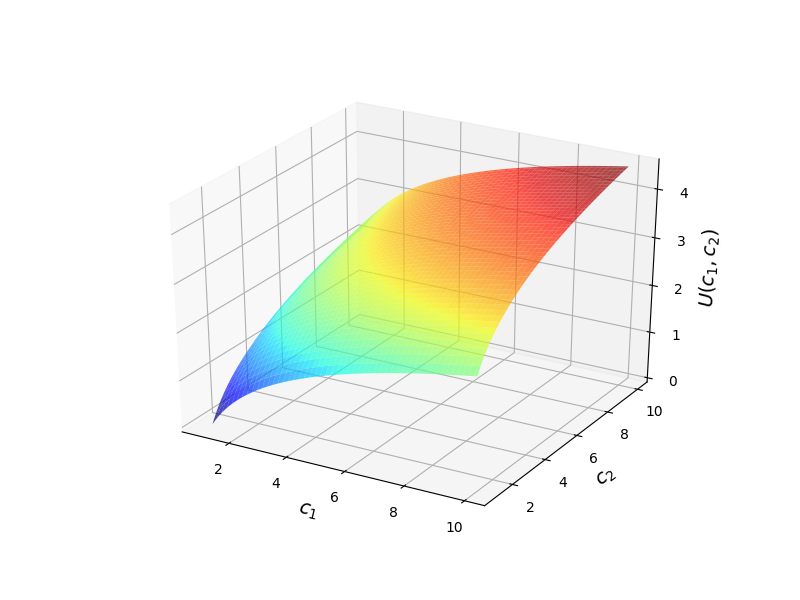

In [5]:
fig = plt.figure(figsize=(8,6))  
ax = fig.add_subplot(1,1,1, projection='3d') 
ax.plot_surface(c1,
                c2,
                u([c1,c2]),
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.7,
                linewidth=0.25)
ax.set_xlabel(r'$c_1$', fontsize=14)
ax.set_ylabel(r'$c_2$', fontsize=14)
ax.set_zlabel(r'$U(c_1,c_2)$', fontsize=14)
plt.show()

Next, let's plot some indifference curves. For that we use a contour map:

<IPython.core.display.Javascript object>


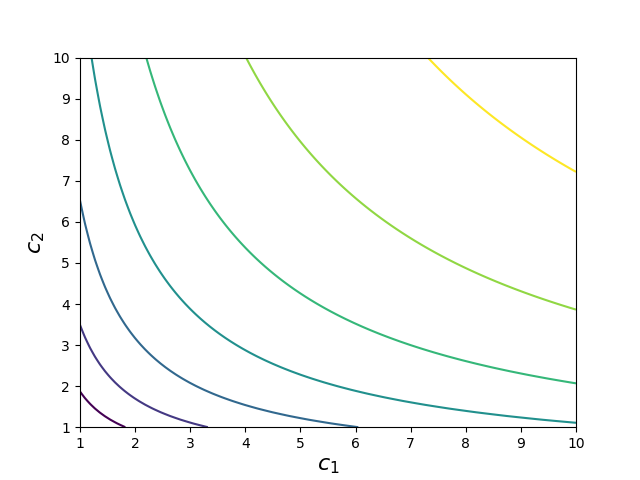

In [6]:
plt.figure()
plt.contour(c1,c2,u([c1,c2]))
plt.xlabel(r'$c_1$',fontsize=16)
plt.ylabel(r'$c_2$',fontsize=16)
plt.show()

In order to solve the maximization problem, we use the contrained optimization solver `SLSQP` available through the Scipy function `minimize`:

In [7]:
from scipy.optimize import minimize

cons = ({'type': 'ineq', 'fun': lambda c:  -c[0] -c[1] + y})

sol = minimize(lambda x: -u(x), ([5, 5]), method='SLSQP', constraints=cons)

sol.x

array([ 5.10046633,  4.89953367])

## 2. A Simple OLG Model

A young person chooses his young and old age consumption, $c_1$ and $c_2$, in order to maximize his lifetime utility:

$$
U(c_1,c_2) = c_1^{1/2} + \beta c_2^{1/2}
$$

subject to the following budget constraints:

$$
\begin{align}
c_1 + v_1 m &\leq y
\\
c_2 &\leq v_2 m
\end{align}
$$

where $m$ is the amount of money acquired by the young and $v_1$ and $v_2$ the price of money in terms of the general good in periods 1 and 2.

We assume the following laws of motion of the stock of money $M_t$ and the population $N_t$ in the economy:
$$
M_{t} = zM_{t-1}
\\
N_{t} = nN_{t-1}
$$
and that all seignorage revenue is used to finance government expenditures.

<br>
When faced with a constrained optimization problem like this one we can either solve it directly or try to use some math and rewrite it as an unconstrained problem. Below, we follow the second path. However, depending on the details of the problem this might not always be possible.

<br>
Since $U$ is strictly increasing in consumption, we know that the two budget constraints will hold with equality which yields:

$$
\begin{align}
c_1 &= y - q
\\
c_2 &= \frac{v_2}{v_1} q
\end{align}
$$
where $q = v_1 m$ are the real money balances acquired by the young.

In addition, from the lecture we know that: $\dfrac{v_2}{v_1} = \dfrac{n}{z}$.

Using the definition above and replacing the modified equality constraints into $U$ yields a simple unconstrained optimization problem:
$$
V = \max_q \,\, U\left(y - q,\frac{n}{z} q \right) = \max_q \,\, (y - q)^{1/2} + \beta \left(\frac{n}{z} q\right)^{1/2}
$$
which we can easily solve using Scipy.

First we set the parameters of the model in an array for fast access: $y = 100 \, , \, z = 1.03 \, , \, n = 1.02 \, , \, \beta = 0.95$

In [8]:
params = np.array([100,1.03,1.02,0.95])

In [9]:
from scipy.optimize import minimize

def U(q,params):
    """
    Returns the lifetime utility of a young person given his choice of real money balances and the parameters of the model
    
    """
    y, z, n, beta = params
    
    u_1 = (y - q) ** (1/2)
    
    u_2 = (n * q / z) ** (1/2)
    
    return u_1 + beta * u_2


def V(params):
    """
    Returns the solution to the young optimization problem given the parameters of the model
    
    """
    
    sol = minimize(lambda q, params: -U(q,params), x0 = 10, args=params, method='Nelder-Mead',options={'ftol': 1e-10})

    return sol

We want now to plot the optimal real balances as a function of the growth rate of money and the growth rate of the population:

In [10]:
z_grid = np.linspace(1.0,11.0,100)
q_star = np.zeros(len(z_grid))
c_1 = np.zeros(len(z_grid))
c_2 = np.zeros(len(z_grid))
u = np.zeros(len(z_grid))

for i, z in enumerate(z_grid):
    params[1] = z
    q_star[i] = V(params).x
    c_1[i] = params[0] - q_star[i]
    c_2[i] = q_star[i] * params[2] / params[1]
    u[i] = U(q_star[i],params)

c = c_1 + c_2

<IPython.core.display.Javascript object>


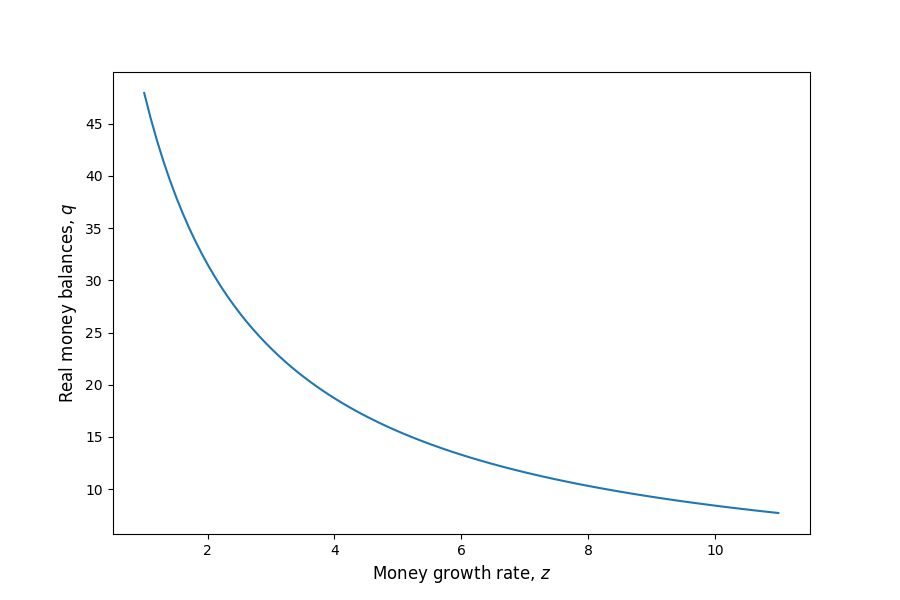

In [11]:
plt.figure(figsize=(9,6))
plt.plot(z_grid,q_star)
plt.ylabel(r'Real money balances, $q$',fontsize='12')
plt.xlabel(r'Money growth rate, $z$',fontsize='12')
plt.show()

Next, we plot $c_1$ and $c_2$ for different levels of $z$ using the previous calculations:

<IPython.core.display.Javascript object>


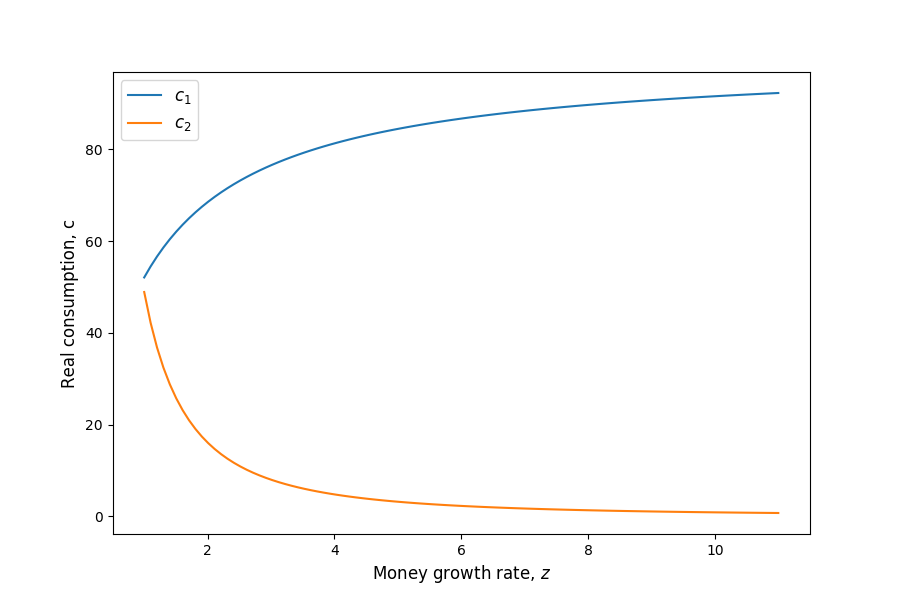

In [12]:
plt.figure(figsize=(9,6))
plt.plot(z_grid,c_1,label=r'$c_1$')
plt.plot(z_grid,c_2,label=r'$c_2$')
plt.ylabel(r'Real consumption, c',fontsize='12')
plt.xlabel(r'Money growth rate, $z$',fontsize='12')
plt.legend(loc='best',fontsize='12')
plt.show()

We can also plot the lifetime consumption and utility as a function of $z$:

<IPython.core.display.Javascript object>


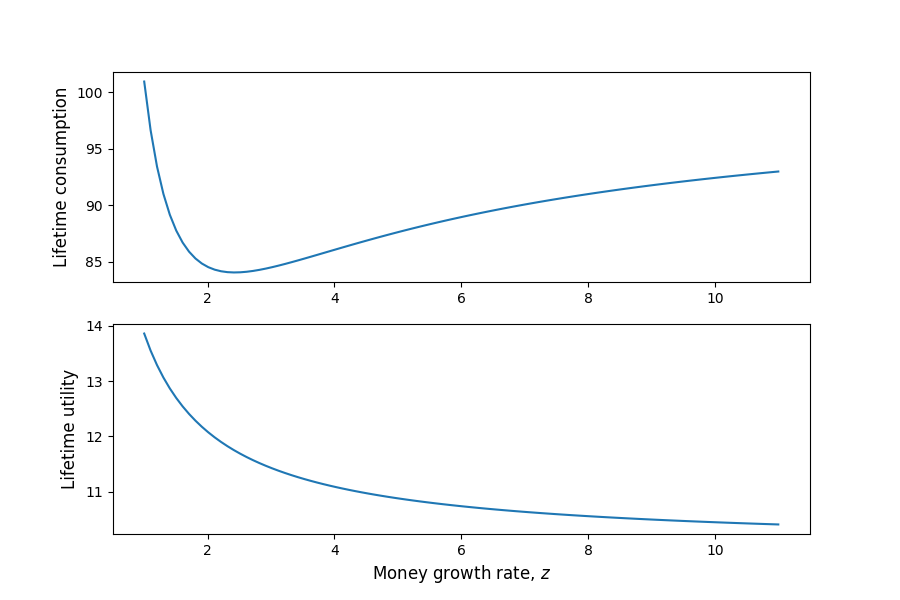

In [13]:
plt.figure(figsize=(9,6))
plt.subplot(2, 1, 1)
plt.plot(z_grid,c,label=r'$c$')
plt.ylabel(r'Lifetime consumption',fontsize='12')

plt.subplot(2, 1, 2)
plt.plot(z_grid,u,label=r'$U$')
plt.xlabel(r'Money growth rate, $z$',fontsize='12')
plt.ylabel(r'Lifetime utility',fontsize='12')

plt.show()

## 3. OLG Model with Seignorage Revenue

Assume now that the newly printed money is used as seignorage revenue by the government:
$$
S_t = \left(1- \frac{1}{z}\right)v_t M_t
$$

Using the money market clearing condition: $v_t M_t = N_t (y - c_{1,t})$ we can write the seignorage income as:
$$
S_t = \left(1- \frac{1}{z}\right)N_t (y - c_{1,t})
$$

The seignorage income per capita $s_t$ will be:
$$
s_t = \left(1- \frac{1}{z}\right)q^*
$$
which we can plot below:

<IPython.core.display.Javascript object>


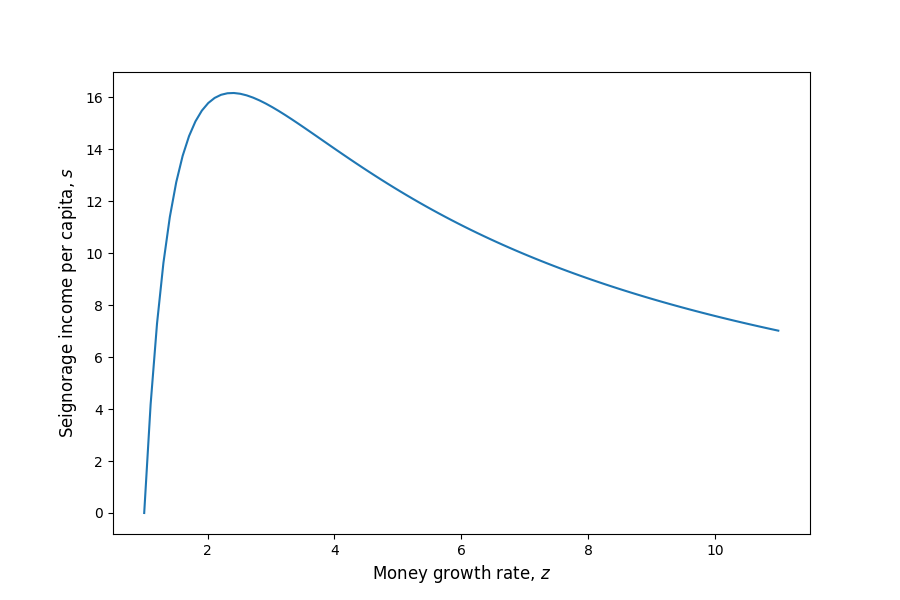

In [14]:
s = ( 1 - (1/z_grid)) * q_star

plt.figure(figsize=(9,6))
plt.plot(z_grid,s)
plt.ylabel(r'Seignorage income per capita, $s$',fontsize='12')
plt.xlabel(r'Money growth rate, $z$',fontsize='12')
plt.show()

We can clearly see that the seignorage income is increasing and then decreasing in the growth rate of money. This means there is a money growth rate maximizing the seignorage income for the government. We can easily compute it by writing a new function that takes the model's parameters as given and returns the seignorage income per capita given the money demand of individuals using the function $V$:

In [15]:
def opt_s(params):
    
    params_new = np.copy(params)  # Make a copy in order to preserve the initial parameters
    
    def s(z,params):  # This is the objective function which takes z as an argument and returns the seignorage income
    
        params[1] = z
    
        return - ((1 - (1/z)) * V(params_new).x)
    
    sol = minimize(s, x0 = 1, args=params_new, method='Nelder-Mead',options={'ftol': 1e-10})
    
    return sol.x[0]

In [16]:
print('The money growth rate maximizing seignorage income is:', opt_s(params))

The money growth rate maximizing seignorage income is: 2.38632820348


Now assume that the government uses the seignorage income $S_t$ and lump-sum tax income $N_t \tau$ to finance a stream of government expenditures $G_t$ such that:
$$
G_t = \left(1- \frac{1}{z}\right)v_t M_t + N_t \tau
$$

Replacing with the money demand and rewriting this in per capita terms we get:
$$
g_t = \left(1- \frac{1}{z}\right)q^* + \tau
$$

Assume $g_t = 20$. We can easily compute the share of $G_t$ financed through lump-sum taxes as a function of money growth rate:

<IPython.core.display.Javascript object>


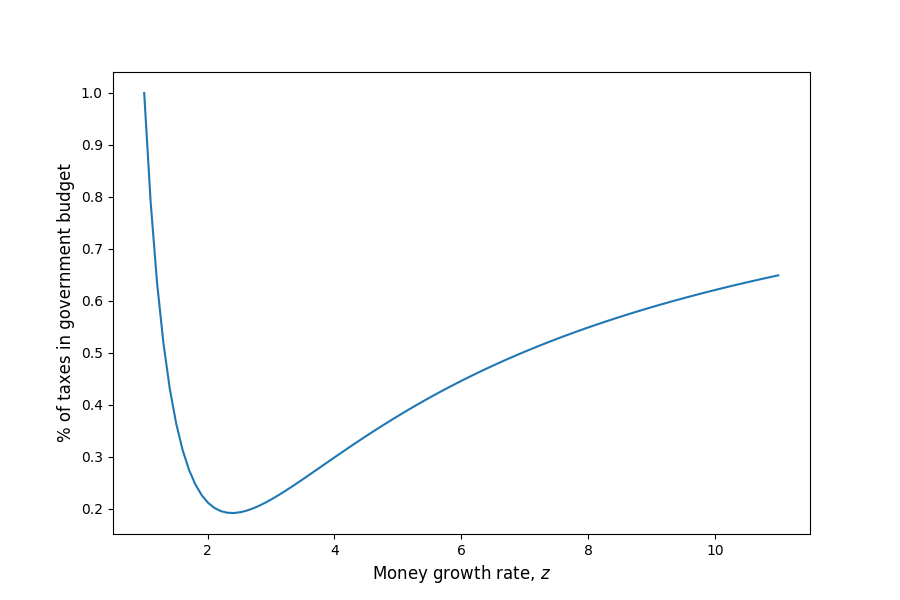

In [17]:
plt.figure(figsize=(9,6))

g = 20

tau = (g - s)/g

plt.plot(z_grid,tau)
plt.ylabel(r'% of taxes in government budget',fontsize='12')
plt.xlabel(r'Money growth rate, $z$',fontsize='12')
plt.show()